# Useful Resources

These are resources for imdb dataset:
- https://arxiv.org/pdf/1801.06146.pdf
- https://arxiv.org/pdf/1705.02364.pdf
- https://github.com/radoslawkrolikowski/sentiment-analysis-pytorch
- https://www.kaggle.com/code/affand20/imdb-with-pytorch

# Installs

In [ ]:
!pip install -q datasets
!pip install -q tqdm
!pip install -q seaborn
!pip install -q scikit-learn
!pip install -q pytorch_lightning
!pip install -q git+https://github.com/MagedSaeed/tkseem

  Preparing metadata (setup.py) ... done


# Prepare

In [ ]:
import re
import os
import random
import string
import shutil
from pathlib import Path

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import torchmetrics
from torchmetrics.functional import word_error_rate, char_error_rate

from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import LightningModule,Trainer
from pytorch_lightning.callbacks import EarlyStopping,LearningRateMonitor,ModelCheckpoint

import datasets
import seaborn as sns
import matplotlib.pyplot as plt


import tkseem as tk
from tqdm.auto import tqdm

In [ ]:
seed = 42

In [ ]:
# random.seed(seed)     # python random generator
# np.random.seed(seed)  # numpy random generator

# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

seed_everything(seed)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [ ]:
tqdm.pandas()

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load and explore the dataset

In [ ]:
dataset = datasets.load_dataset("ag_news")
dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Converting to Pandas and droping duplicates

In [ ]:
train_dataset = dataset['train'].to_pandas()
train_dataset

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2
...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0
119996,Renteria signing a top-shelf deal Red Sox gene...,1
119997,Saban not going to Dolphins yet The Miami Dolp...,1
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1


In [ ]:
train_dataset = train_dataset.drop_duplicates(subset=['text'],keep='first').copy()
train_dataset

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2
...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0
119996,Renteria signing a top-shelf deal Red Sox gene...,1
119997,Saban not going to Dolphins yet The Miami Dolp...,1
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1


In [ ]:
test_dataset = dataset['test'].to_pandas()
test_dataset

,text,label
0,Fears for T N pension after talks Unions repre...,2
1,The Race is On: Second Private Team Sets Launc...,3
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3
...,...,...
7595,Around the world Ukrainian presidential candid...,0
7596,Void is filled with Clement With the supply of...,1
7597,Martinez leaves bitter Like Roger Clemens did ...,1
7598,5 of arthritis patients in Singapore take Bext...,2


In [ ]:
test_dataset = test_dataset.drop_duplicates(subset=['text'],keep='first').copy()
test_dataset

,text,label
0,Fears for T N pension after talks Unions repre...,2
1,The Race is On: Second Private Team Sets Launc...,3
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3
...,...,...
7595,Around the world Ukrainian presidential candid...,0
7596,Void is filled with Clement With the supply of...,1
7597,Martinez leaves bitter Like Roger Clemens did ...,1
7598,5 of arthritis patients in Singapore take Bext...,2


Count positives and negatives

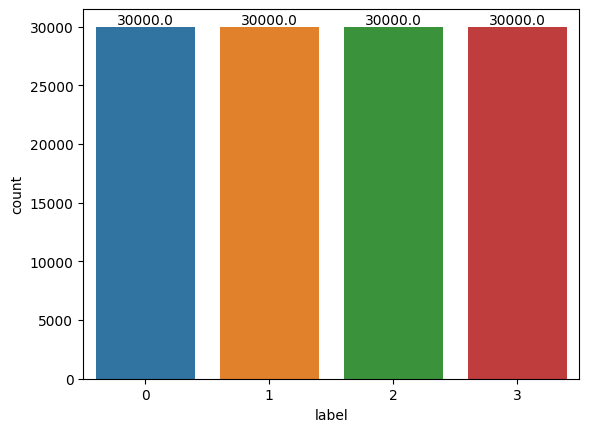

In [ ]:
# Create a count plot
ax = sns.countplot(data=train_dataset, x='label')
# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

trainset vocabulary and tokens count:


In [ ]:
vocabs_dict = {}
for document in train_dataset['text']:
  for word in document.split():
    vocabs_dict[word] = vocabs_dict.get(word,0)+1
f'{len(vocabs_dict.keys()):,}',f'{sum(vocabs_dict.values()):,}'

('188,110', '4,541,694')

# Clean and Preprocess the dataset

In [ ]:
# text cleaning

def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# handle case like "shut up okay?Im only 10 years old"
# become "shut up okay Im only 10 years old"
def rm_punct2(text):
    return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    # return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    # return text.translate(str.maketrans('', '', string.punctuation))

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)        # remove double whitespaces
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):
    text = rm_link(text)
    text = rm_html(text)
    text = space_bt_punct(text)
    text = rm_punct2(text)
    text = rm_number(text)
    text = rm_whitespaces(text)
    text = rm_nonascii(text)
    text = rm_emoji(text)
    text = spell_correction(text)
    return text

In [ ]:
clean_pipeline('the helllo world .')

'the hello world '

In [ ]:
def prepare(text):
  return clean_pipeline(text)

In [ ]:
# test the prepare method
prepare('the good, the bad, and the ugly!')

'the good the bad and the ugly '

In [ ]:
train_dataset['processed'] = list(train_dataset['text'].progress_apply(prepare))
train_dataset

  0%|          | 0/120000 [00:00<?, ?it/s]

,text,label,processed
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Wall St Bears Claw Back Into the Black Reuters...
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Carlyle Looks Toward Commercial Aerospace Reut...
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Oil and Economy Cloud Stocks Outlook Reuters R...
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Iraq Halts Oil Exports from Main Southern Pipe...
4,"Oil prices soar to all-time record, posing new...",2,Oil prices soar to all time record posing new ...
...,...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0,Pakistan s Musharraf Says Won t Quit as Army C...
119996,Renteria signing a top-shelf deal Red Sox gene...,1,Renteria signing a top shelf deal Red Sox gene...
119997,Saban not going to Dolphins yet The Miami Dolp...,1,Saban not going to Dolphins yet The Miami Dolp...
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1,Today s NFL games PITTSBURGH at NY GIANTS Time...


In [ ]:
test_dataset['processed'] = test_dataset['text'].progress_apply(prepare)
test_dataset

  0%|          | 0/7600 [00:00<?, ?it/s]

,text,label,processed
0,Fears for T N pension after talks Unions repre...,2,Fears for T N pension after talks Unions repre...
1,The Race is On: Second Private Team Sets Launc...,3,The Race is On Second Private Team Sets Launch...
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3,Ky Company Wins Grant to Study Peptides AP AP ...
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3,Prediction Unit Helps Forecast Wildfires AP AP...
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3,Calif Aims to Limit Farm Related Smog AP AP So...
...,...,...,...
7595,Around the world Ukrainian presidential candid...,0,Around the world Ukrainian presidential candid...
7596,Void is filled with Clement With the supply of...,1,Void is filled with Clement With the supply of...
7597,Martinez leaves bitter Like Roger Clemens did ...,1,Martinez leaves bitter Like Roger Clemens did ...
7598,5 of arthritis patients in Singapore take Bext...,2,of arthritis patients in Singapore take Bextr...


# Helper functions and constants

In [ ]:
# Find out the max samples token
sorted_docs_by_length = sorted(tqdm(train_dataset['processed']),key=lambda document: len(document.split()),reverse=True)
len(sorted_docs_by_length[0].split()),\
len(sorted_docs_by_length[1].split()),\
len(sorted_docs_by_length[2].split()),\
len(sorted_docs_by_length[5].split()),\
len(sorted_docs_by_length[10].split()),\
len(sorted_docs_by_length[50].split()),\
len(sorted_docs_by_length[1000].split())

  0%|          | 0/120000 [00:00<?, ?it/s]

(180, 175, 173, 158, 148, 134, 74)

In [ ]:
# Find out the max samples token
sorted_docs_by_length = sorted(tqdm(test_dataset['processed']),key=lambda document: len(document.split()),reverse=True)
len(sorted_docs_by_length[0].split()),\
len(sorted_docs_by_length[1].split()),\
len(sorted_docs_by_length[2].split()),\
len(sorted_docs_by_length[5].split()),\
len(sorted_docs_by_length[10].split()),\
len(sorted_docs_by_length[50].split()),\
len(sorted_docs_by_length[1000].split())

  0%|          | 0/7600 [00:00<?, ?it/s]

(143, 138, 137, 127, 119, 76, 47)

In [ ]:
# setting seq_len:
seq_len = 150

In [ ]:
def create_features_from_text_list(text_list,tokenizer):
  encoded = list()
  for doc in tqdm(text_list):
    encoded_doc = tokenizer.encode(doc)
    encoded_doc = tokenizer.pad(encoded_doc,length=seq_len)
    encoded_doc = encoded_doc[:seq_len]
    encoded.append(np.array(encoded_doc))
  return np.array(encoded)

In [ ]:
# define batch size
batch_size = 32

In [ ]:
def mask_vowels(text, mask=""):
    text_with_no_vowels = re.sub(
        r"[AEIOU]",
        mask,
        text,
        flags=re.IGNORECASE,
    )
    return text_with_no_vowels

In [ ]:
def drop_vowel_words(text):
  no_vowel_words_text = ''
  for word in text.split():
    if len(re.sub(
          r"[AEIOU]",
          '',
          word,
          flags=re.IGNORECASE,
      ).strip()) == 0:
      continue
    no_vowel_words_text += f'{word} '
  return no_vowel_words_text.strip()

In [ ]:
print(drop_vowel_words('I am happy'))

am happy


In [ ]:
def drop_consonants(text):
  vowels= ['a','A','e','E','i','I','o','O','u','U']
  vowels_text = ''
  for word in text.split():
    if word == '<UNK>':
      continue
    vowels_word = ''
    for c in word:
      if c in vowels or c.isspace():
        vowels_word += c
    vowels_text += vowels_word
    vowels_text += ' '
  return vowels_text

In [ ]:
print(drop_consonants(text='mississippi is great'))

iiii i ea 


In [ ]:
def calculate_text_metrics(predictions,labels,target_tokenizer, print_text=False):
  # drop pads, those pads are not necessary pad tokens!!
  last_pad = predictions[-1]
  for i,pad in reversed(list(enumerate(predictions))):
    if pad == last_pad:
      predictions.pop(i)
    else:
      break

  predicted_text = ' '.join(target_tokenizer.decode(predictions))
  predicted_text = predicted_text.replace('<PAD>','')
  predicted_text = predicted_text.replace('<sos>','')
  predicted_text = predicted_text.replace('<eos>','')
  predicted_text = re.sub(' +',' ',predicted_text)

  true_text = ' '.join(target_tokenizer.decode(labels))
  true_text = true_text.replace('<PAD>','')
  true_text = true_text.replace('<sos>','')
  true_text = true_text.replace('<eos>','')
  true_text = re.sub(' +',' ',true_text)

  if print_text:
    print(predicted_text)
    print(true_text)

  wer = word_error_rate(preds=predicted_text, target=true_text)
  cer = char_error_rate(preds=predicted_text, target=true_text)

  # calculating vowels error rate (ver) by droping consonants then cer on vowels
  predicted_text_vowels = drop_consonants(predicted_text)
  true_text_vowels = drop_consonants(true_text)
  ver = char_error_rate(preds=predicted_text_vowels,target=true_text_vowels)

  return wer,cer,ver

# Add masked consontants column to the dataset

In [ ]:
train_dataset['processed_consonants'] = train_dataset['processed'].progress_apply(mask_vowels)
train_dataset

  0%|          | 0/120000 [00:00<?, ?it/s]

,text,label,processed,processed_consonants
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Wall St Bears Claw Back Into the Black Reuters...,Wll St Brs Clw Bck nt th Blck Rtrs Rtrs Shrt s...
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Carlyle Looks Toward Commercial Aerospace Reut...,Crlyl Lks Twrd Cmmrcl rspc Rtrs Rtrs Prvt nvst...
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Oil and Economy Cloud Stocks Outlook Reuters R...,l nd cnmy Cld Stcks tlk Rtrs Rtrs Srng crd prc...
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Iraq Halts Oil Exports from Main Southern Pipe...,rq Hlts l xprts frm Mn Sthrn Ppln Rtrs Rtrs th...
4,"Oil prices soar to all-time record, posing new...",2,Oil prices soar to all time record posing new ...,l prcs sr t ll tm rcrd psng nw mnc t S cnmy FP...
...,...,...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0,Pakistan s Musharraf Says Won t Quit as Army C...,Pkstn s Mshrrf Sys Wn t Qt s rmy Chf KRCH Rtrs...
119996,Renteria signing a top-shelf deal Red Sox gene...,1,Renteria signing a top shelf deal Red Sox gene...,Rntr sgnng tp shlf dl Rd Sx gnrl mngr Th pstn...
119997,Saban not going to Dolphins yet The Miami Dolp...,1,Saban not going to Dolphins yet The Miami Dolp...,Sbn nt gng t Dlphns yt Th Mm Dlphns wll pt thr...
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1,Today s NFL games PITTSBURGH at NY GIANTS Time...,Tdy s NFL gms PTTSBRGH t NY GNTS Tm p m Ln Stl...


In [ ]:
train_dataset['processed_no_vowel_words'] = train_dataset['processed'].progress_apply(drop_vowel_words)
train_dataset

  0%|          | 0/120000 [00:00<?, ?it/s]

,text,label,processed,processed_consonants,processed_no_vowel_words
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Wall St Bears Claw Back Into the Black Reuters...,Wll St Brs Clw Bck nt th Blck Rtrs Rtrs Shrt s...,Wall St Bears Claw Back Into the Black Reuters...
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Carlyle Looks Toward Commercial Aerospace Reut...,Crlyl Lks Twrd Cmmrcl rspc Rtrs Rtrs Prvt nvst...,Carlyle Looks Toward Commercial Aerospace Reut...
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Oil and Economy Cloud Stocks Outlook Reuters R...,l nd cnmy Cld Stcks tlk Rtrs Rtrs Srng crd prc...,Oil and Economy Cloud Stocks Outlook Reuters R...
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Iraq Halts Oil Exports from Main Southern Pipe...,rq Hlts l xprts frm Mn Sthrn Ppln Rtrs Rtrs th...,Iraq Halts Oil Exports from Main Southern Pipe...
4,"Oil prices soar to all-time record, posing new...",2,Oil prices soar to all time record posing new ...,l prcs sr t ll tm rcrd psng nw mnc t S cnmy FP...,Oil prices soar to all time record posing new ...
...,...,...,...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0,Pakistan s Musharraf Says Won t Quit as Army C...,Pkstn s Mshrrf Sys Wn t Qt s rmy Chf KRCH Rtrs...,Pakistan s Musharraf Says Won t Quit as Army C...
119996,Renteria signing a top-shelf deal Red Sox gene...,1,Renteria signing a top shelf deal Red Sox gene...,Rntr sgnng tp shlf dl Rd Sx gnrl mngr Th pstn...,Renteria signing top shelf deal Red Sox genera...
119997,Saban not going to Dolphins yet The Miami Dolp...,1,Saban not going to Dolphins yet The Miami Dolp...,Sbn nt gng t Dlphns yt Th Mm Dlphns wll pt thr...,Saban not going to Dolphins yet The Miami Dolp...
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1,Today s NFL games PITTSBURGH at NY GIANTS Time...,Tdy s NFL gms PTTSBRGH t NY GNTS Tm p m Ln Stl...,Today s NFL games PITTSBURGH at NY GIANTS Time...


In [ ]:
test_dataset['processed_consonants'] = test_dataset['processed'].progress_apply(mask_vowels)
test_dataset

  0%|          | 0/7600 [00:00<?, ?it/s]

,text,label,processed,processed_consonants
0,Fears for T N pension after talks Unions repre...,2,Fears for T N pension after talks Unions repre...,Frs fr T N pnsn ftr tlks nns rprsntng wrkrs t ...
1,The Race is On: Second Private Team Sets Launc...,3,The Race is On Second Private Team Sets Launch...,Th Rc s n Scnd Prvt Tm Sts Lnch Dt fr Hmn Spcf...
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3,Ky Company Wins Grant to Study Peptides AP AP ...,Ky Cmpny Wns Grnt t Stdy Pptds P P cmpny fndd...
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3,Prediction Unit Helps Forecast Wildfires AP AP...,Prdctn nt Hlps Frcst Wldfrs P P t s brly dwn w...
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3,Calif Aims to Limit Farm Related Smog AP AP So...,Clf ms t Lmt Frm Rltd Smg P P Sthrn Clfrn s sm...
...,...,...,...,...
7595,Around the world Ukrainian presidential candid...,0,Around the world Ukrainian presidential candid...,rnd th wrld krnn prsdntl cnddt Vktr Yshchnk ws...
7596,Void is filled with Clement With the supply of...,1,Void is filled with Clement With the supply of...,Vd s flld wth Clmnt Wth th spply f ttrctv ptch...
7597,Martinez leaves bitter Like Roger Clemens did ...,1,Martinez leaves bitter Like Roger Clemens did ...,Mrtnz lvs bttr Lk Rgr Clmns dd lmst xctly ght ...
7598,5 of arthritis patients in Singapore take Bext...,2,of arthritis patients in Singapore take Bextr...,f rthrts ptnts n Sngpr tk Bxtr r Clbrx lt b g...


In [ ]:
test_dataset['processed_no_vowel_words'] = test_dataset['processed'].progress_apply(drop_vowel_words)
test_dataset

  0%|          | 0/7600 [00:00<?, ?it/s]

,text,label,processed,processed_consonants,processed_no_vowel_words
0,Fears for T N pension after talks Unions repre...,2,Fears for T N pension after talks Unions repre...,Frs fr T N pnsn ftr tlks nns rprsntng wrkrs t ...,Fears for T N pension after talks Unions repre...
1,The Race is On: Second Private Team Sets Launc...,3,The Race is On Second Private Team Sets Launch...,Th Rc s n Scnd Prvt Tm Sts Lnch Dt fr Hmn Spcf...,The Race is On Second Private Team Sets Launch...
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3,Ky Company Wins Grant to Study Peptides AP AP ...,Ky Cmpny Wns Grnt t Stdy Pptds P P cmpny fndd...,Ky Company Wins Grant to Study Peptides AP AP ...
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3,Prediction Unit Helps Forecast Wildfires AP AP...,Prdctn nt Hlps Frcst Wldfrs P P t s brly dwn w...,Prediction Unit Helps Forecast Wildfires AP AP...
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3,Calif Aims to Limit Farm Related Smog AP AP So...,Clf ms t Lmt Frm Rltd Smg P P Sthrn Clfrn s sm...,Calif Aims to Limit Farm Related Smog AP AP So...
...,...,...,...,...,...
7595,Around the world Ukrainian presidential candid...,0,Around the world Ukrainian presidential candid...,rnd th wrld krnn prsdntl cnddt Vktr Yshchnk ws...,Around the world Ukrainian presidential candid...
7596,Void is filled with Clement With the supply of...,1,Void is filled with Clement With the supply of...,Vd s flld wth Clmnt Wth th spply f ttrctv ptch...,Void is filled with Clement With the supply of...
7597,Martinez leaves bitter Like Roger Clemens did ...,1,Martinez leaves bitter Like Roger Clemens did ...,Mrtnz lvs bttr Lk Rgr Clmns dd lmst xctly ght ...,Martinez leaves bitter Like Roger Clemens did ...
7598,5 of arthritis patients in Singapore take Bext...,2,of arthritis patients in Singapore take Bextr...,f rthrts ptnts n Sngpr tk Bxtr r Clbrx lt b g...,of arthritis patients in Singapore take Bextra...


# Build the BiLSTM Model

In [ ]:
# model architecture (with some amends)
# https://www.kaggle.com/code/affand20/imdb-with-pytorch

class LitBiLSTMModel(LightningModule):
    def __init__(
        self,
        vocab_size,
        output_size,
        pad_id=1, # the default value from tkseem tokenizers
        seq_len=seq_len,
        hidden_size=512,
        embedding_size=512,
        embedding_dropout=0.25,
        dropout=0.33,
        learning_rate=0.001,
        n_layers=2,
        bidirectional=True,
      ):
        super().__init__()

        self.save_hyperparameters()

        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.dropout_prop = dropout
        self.pad_id = pad_id
        self.max_sequence_length = seq_len
        self.output_size = output_size

        self.train_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_id,
          )
        self.val_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_id,
          )
        self.test_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_id,
          )

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(
              embedding_size,
              hidden_size,
              n_layers,
              dropout=dropout,
              batch_first=True,
              bidirectional=bidirectional,
        )

        # dropout layer
        self.dropout = nn.Dropout(dropout)
        self.embedding_dropout = nn.Dropout(embedding_dropout)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        outputs = self.embedding(inputs)
        outputs = self.embedding_dropout(outputs) # apply dropout on embedding
        inputs_lengths = torch.sum(inputs!=self.pad_id,axis=-1).cpu()
        packed_outputs = nn.utils.rnn.pack_padded_sequence(
            outputs,
            inputs_lengths,
            batch_first=True,
            enforce_sorted=False,
          )
        if not self.bidirectional:
          # pass forward to lstm
          packed_outputs, _ =  self.lstm(packed_outputs)
          outputs,lengths = nn.utils.rnn.pad_packed_sequence(
              packed_outputs,
              batch_first=True,
              total_length=self.max_sequence_length,
            )
        else:
          bidirectional_packed_outputs,_ = self.lstm(packed_outputs)
          bidirectional_outputs,lengths = nn.utils.rnn.pad_packed_sequence(
              bidirectional_packed_outputs,
              batch_first=True,
              # padding_value=self.pad_id,
              total_length=self.max_sequence_length,
            )
          outputs = bidirectional_outputs[:, :, : self.hidden_size] + bidirectional_outputs[:, :, self.hidden_size :]
        outputs = self.dropout(outputs)
        outputs = self.fc(outputs)
        # softmax will be done in the loss calculation
        return outputs

    def step(self, inputs, labels):
        assert torch.sum(inputs==self.pad_id)==torch.sum(labels==self.pad_id),\
             f'pad ids and their target tags does not match: {torch.sum(inputs==self.pad_id):=} != {torch.sum(labels==self.pad_id):=}'
        outputs = self(inputs)
        outputs = outputs.squeeze()
        outputs = outputs.view(outputs.shape[0]*outputs.shape[1],-1)
        labels = labels.view(-1)
        return outputs,labels

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs,labels = self.step(inputs, labels)
        loss = F.cross_entropy(
            outputs,
            labels,
            ignore_index=self.pad_id,
          )
        train_accuracy = self.train_accuracy(outputs, labels)
        self.log(
            "loss",
            loss,
            prog_bar=True,
            on_step=True,
            on_epoch=False,
        )
        self.log(
            "train_acc",
            train_accuracy,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
        )
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs,labels = self.step(inputs, labels)
        loss = F.cross_entropy(
            outputs,
            labels,
            ignore_index=self.pad_id,
          )
        val_accuracy = self.val_accuracy(outputs, labels)
        self.log("val_loss", loss, prog_bar=True)
        self.log(
            "val_acc",
            val_accuracy,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
        )
        return {"val_loss": loss}

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs,labels = self.step(inputs, labels)
        loss = F.cross_entropy(
            outputs,
            labels,
            ignore_index=self.pad_id,
          )
        test_accuracy = self.test_accuracy(outputs,labels)
        metrics = {"test_acc": test_accuracy, "test_loss": loss}
        self.log_dict(metrics, prog_bar=True)
        return outputs

    def predict_step(self, batch, batch_idx):
      inputs,labels = batch
      outputs,labels = self.step(inputs,labels)
      predictions = torch.argmax(outputs,dim=-1)
      return predictions,labels

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            factor=0.5,
            patience=1,
            verbose=True,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }

In [ ]:
def get_best_checkpoint(text_type,checkpoints_base_path="./TopciModeling"):
    checkpoints_path = (
        f"{checkpoints_base_path}/{text_type}/checkpoints"
    )
    for file_name in os.listdir(checkpoints_path):
        if file_name.startswith("epoch"):
            return f"{checkpoints_path}/{file_name}"

In [ ]:
def train_model(
    model,
    train_dataloader,
    val_dataloader,
    text_type,
    max_epochs=50,
  ):
  checkpoints_path = Path(f"./TopciModeling/{text_type}")
  shutil.rmtree(checkpoints_path, ignore_errors=True)
  checkpoint_callback = ModelCheckpoint(
      mode="min",
      save_top_k=1,
      verbose=False,
      save_last=True,
      monitor="val_loss",
      save_weights_only=False,
      auto_insert_metric_name=True,
      save_on_train_epoch_end=False,
      dirpath=f"{checkpoints_path}/checkpoints",
      filename="{epoch}-{val_loss:.3f}-{step}",
  )
  callbacks = list()
  callbacks.append(checkpoint_callback)
  early_stopping_callback = EarlyStopping(
      monitor="val_loss",
      # min_delta=0.025,
      min_delta=0,
      patience=6,
      check_finite=True,
  )
  callbacks.append(early_stopping_callback)
  lr_monitor = LearningRateMonitor(
      logging_interval="step",
      log_momentum=True,
  )
  callbacks.append(lr_monitor)
  devices = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  trainer = Trainer(
      deterministic=True,
      callbacks=callbacks,
      gradient_clip_val=5,
      fast_dev_run=False,
      max_epochs=max_epochs,
      val_check_interval=0.5,
      accelerator="auto",
      # log_every_n_steps=max(len(train_dataloader) // 25, 1),
      log_every_n_steps=max(len(train_dataloader) // 25, 1),
  )
  trainer.validate(
      model=model,
      dataloaders=val_dataloader,
  )
  trainer.fit(
      model,
      train_dataloader,
      val_dataloader,
  )
  return trainer

# Prepare vocab

## source tokenizer

In [ ]:
source_tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [ ]:
source_tokenizer.train(text='\n'.join(train_dataset['processed_consonants']))

Training WordTokenizer ...


In [ ]:
source_tokenizer.train(text='\n'.join(train_dataset['processed_consonants']))

Training WordTokenizer ...


In [ ]:
source_tokenizer.vocab_size

57985

In [ ]:
# test the tokenizer
source_tokenizer.tokenize('th hll wrld , frctnlly')

['th', 'hll', 'wrld', '<UNK>', 'frctnlly']

## target tokenizer

In [ ]:
target_tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [ ]:
target_tokenizer.train(text='\n'.join(train_dataset['processed']))

Training WordTokenizer ...


In [ ]:
target_tokenizer.train(text='\n'.join(train_dataset['processed']))

Training WordTokenizer ...


In [ ]:
target_tokenizer.vocab_size

84689

In [ ]:
# test the tokenizer
target_tokenizer.tokenize('the hello world , fractionally . I am happy')

['the', 'hello', 'world', '<UNK>', 'fractionally', '<UNK>', 'I', 'am', 'happy']

# Run the experiment

## tokenize and split

In [ ]:
encoded_trainset = create_features_from_text_list(text_list=train_dataset['processed_consonants'],tokenizer=source_tokenizer)
trainy = create_features_from_text_list(text_list=train_dataset['processed_no_vowel_words'],tokenizer=target_tokenizer)

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

In [ ]:
encoded_testset = create_features_from_text_list(text_list=test_dataset['processed_consonants'],tokenizer=source_tokenizer)
testy = create_features_from_text_list(text_list=test_dataset['processed_no_vowel_words'],tokenizer=target_tokenizer)

  0%|          | 0/7600 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

In [ ]:
testy_with_vowel_words = create_features_from_text_list(text_list=test_dataset['processed'],tokenizer=target_tokenizer)

  0%|          | 0/7600 [00:00<?, ?it/s]

In [ ]:
encoded_trainset, encoded_valset, trainy, valy = train_test_split(
  encoded_trainset,
  trainy,
  test_size=0.1,
  random_state=seed,
)
len(encoded_trainset),len(encoded_valset),len(trainy), len(valy)

(108000, 12000, 108000, 12000)

In [ ]:
# create tensor datasets
trainset = TensorDataset(torch.from_numpy(encoded_trainset), torch.from_numpy(trainy))
validset = TensorDataset(torch.from_numpy(encoded_valset), torch.from_numpy(valy))
testset = TensorDataset(torch.from_numpy(encoded_testset), torch.from_numpy(testy))
testset_with_vowel_words = TensorDataset(torch.from_numpy(encoded_testset), torch.from_numpy(testy_with_vowel_words))

In [ ]:
# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size,num_workers=4)
valloader = DataLoader(validset, shuffle=False, batch_size=batch_size,num_workers=4,drop_last=False)
testloader = DataLoader(testset, shuffle=False, batch_size=batch_size,num_workers=4,drop_last=False)
testloader_with_vowel_words = DataLoader(testset_with_vowel_words,shuffle=False,batch_size=batch_size,num_workers=4,drop_last=False)

## build and train the model

In [ ]:
model = LitBiLSTMModel(
    vocab_size=source_tokenizer.vocab_size,
    output_size=target_tokenizer.vocab_size,
  )
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(57985, 512)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.33, bidirectional=True)
  (dropout): Dropout(p=0.33, inplace=False)
  (embedding_dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=512, out_features=84689, bias=True)
)

In [ ]:
trainer = train_model(
    model,
    train_dataloader=trainloader,
    val_dataloader=valloader,
    text_type='all-characters',
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     11.34575366973877     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | train_accuracy    | MulticlassAccuracy | 0     
1 | val_accuracy      | MulticlassAccuracy | 0     
2 | test_accuracy     | MulticlassAccuracy | 0     
3 | embedding         | Embedding          | 29.7 M
4 | lstm              | LSTM               | 10.5 M
5 | dropout           | Dropout            | 0     
6 | embedding_dropout | Dropout            | 0     
7 | fc                | Linear             | 43.4 M
---------------------------------------------------------
83.6 M    Trainable params
0         Non-trainable params
83.6 M    Total params
334.544   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00021: reducing learning rate of group 0 to 2.5000e-04.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
trainer.test(model,testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9367131590843201     │
│         test_loss         │    0.37344929575920105    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9367131590843201, 'test_loss': 0.37344929575920105}]

find the text metrics, (wer,cer,ver)

In [ ]:
model_predictions = trainer.predict(model,testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
predictions = list()
labels = list()
for (batch_predictions,batch_labels) in model_predictions:
  batch_predictions = batch_predictions.view(-1,seq_len)
  batch_labels = batch_labels.view(-1,seq_len)
  for sample_predictions,sample_labels in zip(batch_predictions,batch_labels):
    predictions.append(sample_predictions)
    labels.append(sample_labels)
print('len predictions and lables of the test set:',len(predictions),len(labels))

len predictions and lables of the test set: 7600 7600


In [ ]:
wers,cers,vers = list(),list(),list()
for sample_preds,sample_labels in tqdm(zip(predictions,labels),total=len(predictions)):
  wer,cer,ver = calculate_text_metrics(
      predictions=sample_preds.tolist(),
      labels=sample_labels.tolist(),
      target_tokenizer=target_tokenizer,
    )
  wers.append(wer)
  cers.append(cer)
  vers.append(ver)

  0%|          | 0/7600 [00:00<?, ?it/s]

In [ ]:
avg_wer = sum(wers)/len(wers)
avg_cer = sum(cers)/len(cers)
avg_ver = sum(vers)/len(vers)
print('avg_wer, avg_cer, avg_ver:',avg_wer,avg_cer,avg_ver)

avg_wer, avg_cer, avg_ver: tensor(0.0640) tensor(0.0315) tensor(0.0385)


text metrics with vowel words loader

In [ ]:
labels_with_vowel_words = list()
for batch in testloader_with_vowel_words:
  _,batch_labels = batch
  batch_labels = batch_labels.view(-1,seq_len)
  for sample_labels in batch_labels:
    labels_with_vowel_words.append(sample_labels)
print('len lables with vowel words of the test set:',len(labels_with_vowel_words))

len lables with vowel words of the test set: 7600


In [ ]:
wers,cers,vers = list(),list(),list()
for sample_preds,sample_labels in tqdm(zip(predictions,labels_with_vowel_words),total=len(predictions)):
  wer,cer,ver = calculate_text_metrics(
      predictions=sample_preds.tolist(),
      labels=sample_labels.tolist(),
      target_tokenizer=target_tokenizer,
    )
  wers.append(wer)
  cers.append(cer)
  vers.append(ver)

  0%|          | 0/7600 [00:00<?, ?it/s]

In [ ]:
avg_wer = sum(wers)/len(wers)
avg_cer = sum(cers)/len(cers)
avg_ver = sum(vers)/len(vers)
print('avg_wer, avg_cer, avg_ver:',avg_wer,avg_cer,avg_ver)

avg_wer, avg_cer, avg_ver: tensor(0.0899) tensor(0.0406) tensor(0.0560)


test on the best model according to the validation loss

In [ ]:
model = LitBiLSTMModel.load_from_checkpoint(
    get_best_checkpoint(text_type='all-characters',),
    vocab_size=source_tokenizer.vocab_size,
    output_size=target_tokenizer.vocab_size,
  )
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(57985, 512)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.33, bidirectional=True)
  (dropout): Dropout(p=0.33, inplace=False)
  (embedding_dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=512, out_features=84689, bias=True)
)

In [ ]:
trainer.test(model,testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9355722665786743     │
│         test_loss         │    0.37777888774871826    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9355722665786743, 'test_loss': 0.37777888774871826}]

In [ ]:
model_predictions = trainer.predict(model,testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
predictions = list()
labels = list()
for (batch_predictions,batch_labels) in model_predictions:
  batch_predictions = batch_predictions.view(-1,seq_len)
  batch_labels = batch_labels.view(-1,seq_len)
  for sample_predictions,sample_labels in zip(batch_predictions,batch_labels):
    predictions.append(sample_predictions)
    labels.append(sample_labels)
print('len predictions and lables of the test set:',len(predictions),len(labels))

len predictions and lables of the test set: 7600 7600


In [ ]:
wers,cers,vers = list(),list(),list()
for sample_preds,sample_labels in tqdm(zip(predictions,labels),total=len(predictions)):
  wer,cer,ver = calculate_text_metrics(
      predictions=sample_preds.tolist(),
      labels=sample_labels.tolist(),
      target_tokenizer=target_tokenizer
    )
  wers.append(wer)
  cers.append(cer)
  vers.append(ver)

  0%|          | 0/7600 [00:00<?, ?it/s]

In [ ]:
avg_wer = sum(wers)/len(wers)
avg_cer = sum(cers)/len(cers)
avg_ver = sum(vers)/len(vers)
print('avg_wer, avg_cer, avg_ver:',avg_wer,avg_cer,avg_ver)

avg_wer, avg_cer, avg_ver: tensor(0.0650) tensor(0.0317) tensor(0.0388)


text metrics with vowel words

In [ ]:
labels_with_vowel_words = list()
for batch in testloader_with_vowel_words:
  _,batch_labels = batch
  batch_labels = batch_labels.view(-1,seq_len)
  for sample_labels in batch_labels:
    labels_with_vowel_words.append(sample_labels)
print('len lables with vowel words of the test set:',len(labels_with_vowel_words))

len lables with vowel words of the test set: 7600


In [74]:
wers,cers,vers = list(),list(),list()
for sample_preds,sample_labels in tqdm(zip(predictions,labels_with_vowel_words),total=len(predictions)):
  wer,cer,ver = calculate_text_metrics(
      predictions=sample_preds.tolist(),
      labels=sample_labels.tolist(),
      target_tokenizer=target_tokenizer,
    )
  wers.append(wer)
  cers.append(cer)
  vers.append(ver)

  0%|          | 0/7600 [00:00<?, ?it/s]

In [75]:
avg_wer = sum(wers)/len(wers)
avg_cer = sum(cers)/len(cers)
avg_ver = sum(vers)/len(vers)
print('avg_wer, avg_cer, avg_ver:',avg_wer,avg_cer,avg_ver)

avg_wer, avg_cer, avg_ver: tensor(0.0909) tensor(0.0407) tensor(0.0564)


In [76]:
for sample_preds,sample_labels in tqdm(list(zip(predictions,labels_with_vowel_words))[:100],total=100):
  wer,cer,ver = calculate_text_metrics(
      predictions=sample_preds.tolist(),
      labels=sample_labels.tolist(),
      target_tokenizer=target_tokenizer,
      print_text=True
    )

  0%|          | 0/100 [00:00<?, ?it/s]

Fears for ATA UN pension after talks unions representing workers at Turner Newell say they are disappointed after talks with stricken parent from Federal Miguel
Fears for T N pension after talks Unions representing workers at Turner Newall say they are disappointed after talks with stricken parent firm Federal Mogul 
The Race Is in Second Private Team Sites Launch Date for Human Spaceflight SPACE com SPACE com TORONTO Canada second time of rocketeers competing for the million Ansari X Prize contest for privately funded suborbital space flight has officially announced the first launch date for its manned rocket
The Race is On Second Private Team Sets Launch Date for Human Spaceflight SPACE com SPACE com TORONTO Canada A second team of rocketeers competing for the million Ansari X Prize a contest for privately funded suborbital space flight has officially announced the first launch date for its manned rocket 
Key Company Wins Grant to Study Peptides AP AP company founded by chemistry res

In [ ]:
# from google.colab import runtime
# runtime.unassign()